In [1]:
import hyperiax


from hyperiax.tree.topology import symmetric_topology, asymmetric_topology, read_topology, write_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree

from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology, asymmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax



# Rate likelihood estimation

This document is combined with the R simulations, and take the results the simulations from there and compare the results

In [2]:
# Read tree, with edge lengths here

#tree_string = open("./R/data-R/tree.tre", "r").read()
#tree = read_topology(tree_string,return_topology=False,precompute_child_gathers=True)

#plot_tree(tree,inc_names=True)


   0
 ┌─┴─┐
 1   2 
┌┴┐ ┌┴┐
3 4 5 6


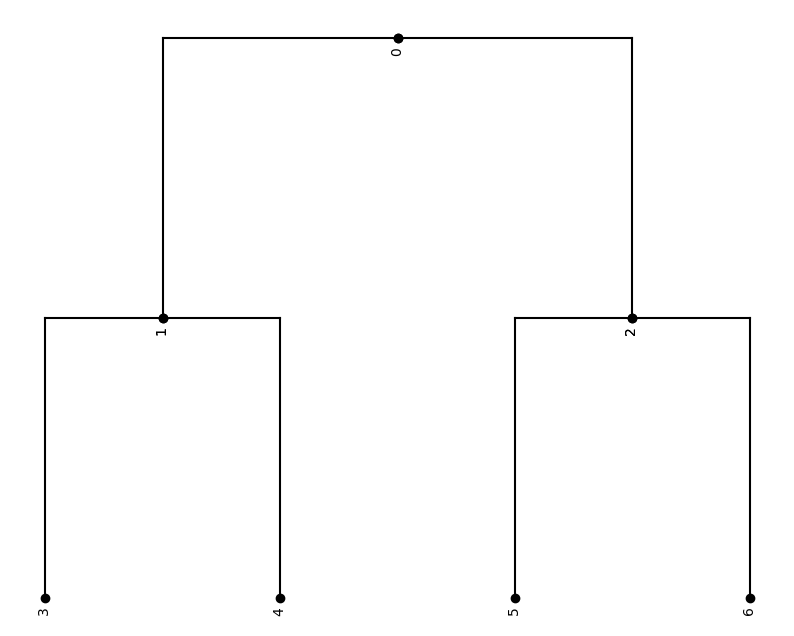

In [3]:
import hyperiax


from hyperiax.tree.topology import symmetric_topology, asymmetric_topology, read_topology, write_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree

from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology, asymmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax
#topology = symmetric_topology(height=2, degree=2)
#topology = asymmetric_topology(2)
key = PRNGKey(0)

topology = symmetric_topology(height=2, degree=2)

tree = HypTree(topology, precompute_child_gathers=True)


# Propreties of the tree

# Branch/edge length, assumed to be constant one 
tree.add_property('edge_length', shape=(1,))

tree.data["edge_length"]  = jnp.array([1.0] * tree.size)
#tree.data["edge_length"]  = jnp.array([0.1, 2.0, 0.3, 0.6, 0.5, 1.0, 0.0])

for i,node in enumerate(tree.iter_topology_bfs()):
    node.name = str(i)


# plot tree again 
plot_tree_text(tree)
plot_tree(tree,inc_names=True)


tree.add_property('estimated_value', shape=(2,))
tree.add_property('value', shape=(2,))

tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(jax.random.bernoulli(key, p=0.5, shape=(sum(tree.is_leaf),2)))


leaf_data = tree.data['value'][tree.is_leaf]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.is_leaf].set(leaf_data)

leaf_edgelength = tree.data['edge_length'][tree.is_leaf]

In [4]:
import pandas as pd
# Add the data to the tree


tree.add_property('alpha', shape=(1,))
tree.add_property('beta', shape=(1,))





# Hyperiax implementaiton of the likelihood estimator


In [5]:
# Define rate matrix, which is 2x2 as a function of input of alpha and beta
# as a function 
Q_rate_matrix = lambda alpha, beta: jnp.array([[-alpha, alpha], [beta, -beta]])

prob_estimation = lambda character, length, alpha, beta: jnp.dot(character, jax.scipy.linalg.expm(Q_rate_matrix(alpha, beta) * length))

def probability_function(value,child_estimated_value, child_edge_length,leaf_mask, child_alpha, child_beta,**kwargs):
    # Assume all rows in child_params are identical
    alpha = child_alpha[0,0].astype(float)[0]  # Extract first value assuming they are the same
    beta = child_beta[0,0].astype(float)[0]  # Extract first value assuming they are the same

    # Use the prob_estimation function defined at module level and vectorize the operation
    probs = jax.vmap(lambda x, y: prob_estimation(x, y, alpha, beta),in_axes=0)(child_estimated_value, child_edge_length)

    # Compute the product along axis 1
    prods = jnp.prod(probs, axis=1)

    # Rescale the likelihood
    result = prods / jnp.sum(prods, axis=1, keepdims=True)

    # Mask padding
    result = jnp.where(leaf_mask[:, None], value, result)
    return {'estimated_value': prods}






In [6]:


upmodel = UpLambda(up_fn=probability_function)
upmodelexe = OrderedExecutor(upmodel)

In [9]:
pi_root = jnp.array([0.5,0.5])


def negative_log_likelihood(pred_root):
    #print(jnp.log(jnp.sum(pi_root*pred_root)))
    return float(jnp.log(jnp.sum(pi_root*pred_root)))


# Create grid of alpha and beta values
alphas = jnp.linspace(0.01, 0.99, 20)
betas = jnp.linspace(0.01, 0.99, 20)

# Initialize array to store results
results = jnp.zeros((len(alphas), len(betas)))

# Calculate negative log likelihood for each combination
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        tree.data['alpha'] = tree.data['alpha'].at[:].set(jnp.array([alpha]))
        tree.data['beta'] = tree.data['beta'].at[:].set(jnp.array([beta]))

        res = upmodelexe.up(tree)

        pred_root = jnp.array(tree.data["estimated_value"][tree.is_root])[0]
        results = results.at[i,j].set(negative_log_likelihood(pred_root))

# Print results
print("Negative log likelihood values for different alpha-beta combinations:")
#print(results)

# Find best parameters
min_idx = jnp.argmin(results)
best_i, best_j = min_idx // len(betas), min_idx % len(betas)
print(f"\nBest parameters:")
print(f"Alpha: {alphas[best_i]:.3f}")
print(f"Beta: {betas[best_j]:.3f}")
print(f"Negative log likelihood: {results[best_i, best_j]:.3f}")



Negative log likelihood values for different alpha-beta combinations:

Best parameters:
Alpha: 0.010
Beta: 0.010
Negative log likelihood: -5.338


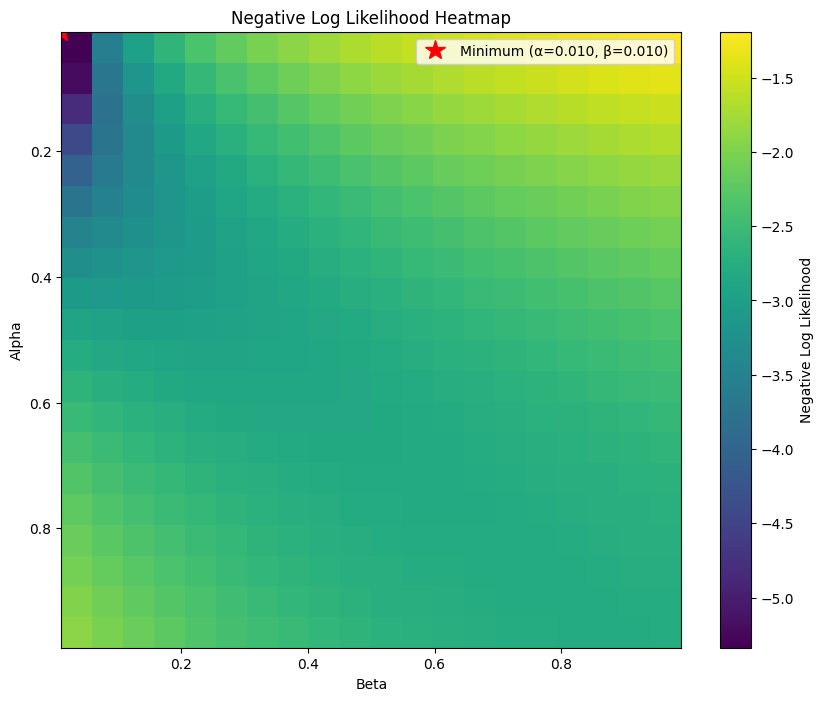

In [10]:
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(results, cmap='viridis', aspect='auto',
           extent=[betas[0], betas[-1], alphas[-1], alphas[0]])  # Flip alpha axis
plt.colorbar(label='Negative Log Likelihood')

# Add labels and title
plt.xlabel('Beta')
plt.ylabel('Alpha') 
plt.title('Negative Log Likelihood Heatmap')

# Mark the minimum point
plt.plot(betas[best_j], alphas[best_i], 'r*', markersize=15,
         label=f'Minimum (α={alphas[best_i]:.3f}, β={betas[best_j]:.3f})')
plt.legend()

plt.show()